# PROYECTO PREPARACIÓN Y LIMPIEZA DE DATOS

## Health Insurance Cross Sell Prediction

El proyecto a desarrollar consta de datos de clientes que una compañia de seguros ha cedido para realizar un modelo predictivo y decidir si los clientes de la anualidad anterior sería elegibles para ofrecerles una póliza para su coche.

El valor que el proyecto aporta a la compañia está relacionado con optimizar los costes de las campañas de marketing y así reducir los costes y eitar publicidad innecesaria a clientes que haya poca o nula posibilidad que contarten dicho seguro para su coche.

El proyecto consiste en dos datasets, uno para realizar el entrenamiento del modelo y otro para realizar el test y comprobar su rendimiento. 

El dataset ha sido obtenido de Kaggle: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction?resource=download&select=train.csv

---------------------------------------------------------------------------------------------------------------------------------------------------

# Prerrequisitos

### Importar librerías

In [76]:
import kagglehub
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import numpy as np
from  sklearn import model_selection

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/health-insurance-cross-sell-prediction")

print("Path to dataset files:", path)

path_to_train = path + "/train.csv" 
path_to_test = path + "/test.csv"



Path to dataset files: /home/mendi/.cache/kagglehub/datasets/anmolkumar/health-insurance-cross-sell-prediction/versions/1


Con este código descargamos el dataset directamente de Kaggle si no se tiene descargado en local. Este método ayuda mucho a una posterior ejecución en otro entorno 

### Cargamos el dataset 

In [4]:
df_train = pl.read_csv(path_to_train)
df_test = pl.read_csv(path_to_test)


### Columnas del dataset 

Ahora, para predecir si el cliente estará interesado en un seguro de vehículo, se dispone de información sobre datos demográficos (sexo, edad, tipo de código regional), vehículos (antigüedad del vehículo, daños), póliza (prima, canal de contratación), etc.

1. id: Identificador unico ID de cada cliente.

2. Gender: Género del asegurado.

3. Age: Edad del asegurado.

4. Driving_License: 0: El asegurado no tiene permiso de conducción, 1: El asegurado tiene permiso de conducción.

5. Region_Code: Código único para la región a la que pertenece el asegurado.

6. Previously_Insured: 0: El cliente no tiene una póliza de seguro para el vehículo con la compañia, 1: El cliente ya tiene contratada una póliza de seguro de vehículo con la compañia.

7. Vehicle_Age: Edad del vehículo.

8. Vehicle_Damage: 0: El vehículo del asegurado no ha tenido daños en el pasado, 1: El vehículo del asegurado ha tenido daños en el pasado.

9. Annual_Premium: La prima de cada cliente

10. Policy_Sales_Channel: Código anónimo para el canal de contacto con el cliente, es decir, diferentes agentes, por correo, por teléfono, en persona, etc.

11. Vintage: Numero de días que el cliente ha estado asociado a la compañia

12. Response: 0: El cliente no está interesado en una póliza para el vehículo, 1: El cliente está interesado en una póliza para el vehículo.

---------------------------------------------------------------------------------------------------------------------------------------------------

# 1 Entendiendo el dataset

### 1.1 - Check the head, shape, data-types of the features

Comprobamos los datatypes de cada columna del dataframe

In [5]:
for column in df_train.columns:
    print(f"{column} : {df_train[column].dtype}")

id : Int64
Gender : String
Age : Int64
Driving_License : Int64
Region_Code : Float64
Previously_Insured : Int64
Vehicle_Age : String
Vehicle_Damage : String
Annual_Premium : Float64
Policy_Sales_Channel : Float64
Vintage : Int64
Response : Int64


Con Polars con el atributo head también se muestra el datatype de cada columna 

In [6]:
df_train.head()

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
i64,str,i64,i64,f64,i64,str,str,f64,f64,i64,i64
1,"""Male""",44,1,28.0,0,"""> 2 Years""","""Yes""",40454.0,26.0,217,1
2,"""Male""",76,1,3.0,0,"""1-2 Year""","""No""",33536.0,26.0,183,0
3,"""Male""",47,1,28.0,0,"""> 2 Years""","""Yes""",38294.0,26.0,27,1
4,"""Male""",21,1,11.0,1,"""< 1 Year""","""No""",28619.0,152.0,203,0
5,"""Female""",29,1,41.0,1,"""< 1 Year""","""No""",27496.0,152.0,39,0


In [7]:
print(df_train.shape)

(381109, 12)


### 1.2 Check the statistical values of features


In [8]:
df_train.describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""count""",381109.0,"""381109""",381109.0,381109.0,381109.0,381109.0,"""381109""","""381109""",381109.0,381109.0,381109.0,381109.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",190555.0,null,38.822584,0.997869,26.388807,0.45821,null,null,30564.389581,112.034295,154.347397,0.122563
"""std""",110016.836208,null,15.511611,0.04611,13.229888,0.498251,null,null,17213.155057,54.203995,83.671304,0.327936
"""min""",1.0,"""Female""",20.0,0.0,0.0,0.0,"""1-2 Year""","""No""",2630.0,1.0,10.0,0.0
"""25%""",95278.0,null,25.0,1.0,15.0,0.0,null,null,24405.0,29.0,82.0,0.0
"""50%""",190555.0,null,36.0,1.0,28.0,0.0,null,null,31669.0,133.0,154.0,0.0
"""75%""",285832.0,null,49.0,1.0,35.0,1.0,null,null,39400.0,152.0,227.0,0.0
"""max""",381109.0,"""Male""",85.0,1.0,52.0,1.0,"""> 2 Years""","""Yes""",540165.0,163.0,299.0,1.0


Podemos observar que el dataset no contiene valores nulos en ninguna de sus columnas


### 1.3 Identifique las columnas que contienen un valor único

Elimine las columnas que contengan un solo valor

In [9]:
columnas_pocos_valores = {}
columnas_muchos_valores = {}

for column in df_train.columns:
    n_unique = df_train[column].n_unique()  # Usa nunique() para obtener el número de valores únicos
    if n_unique < 5:
        columnas_pocos_valores[column] = n_unique
    else:
        columnas_muchos_valores[column] = n_unique

    print(f"{column} : {n_unique}")

id : 381109
Gender : 2
Age : 66
Driving_License : 2
Region_Code : 53
Previously_Insured : 2
Vehicle_Age : 3
Vehicle_Damage : 2
Annual_Premium : 48838
Policy_Sales_Channel : 155
Vintage : 290
Response : 2


In [10]:
print("Columnas con pocos valores:", columnas_pocos_valores)
print("Columnas con muchos valores:", columnas_muchos_valores)

Columnas con pocos valores: {'Gender': 2, 'Driving_License': 2, 'Previously_Insured': 2, 'Vehicle_Age': 3, 'Vehicle_Damage': 2, 'Response': 2}
Columnas con muchos valores: {'id': 381109, 'Age': 66, 'Region_Code': 53, 'Annual_Premium': 48838, 'Policy_Sales_Channel': 155, 'Vintage': 290}


Como se pede observar no eciste ninguna columna con un único valor, las columnas con menos categorías son 2 por lo que no es necesario realizar ninguna operación por ahora.

Podemos observar tambien que las variables con pocos valores son las categoricas mientras que las que tienen muchos valores son las continuas. Vamos a separarlas para estudar la varianza de las variables contínuas.



In [11]:
variables_categoricas = df_train.select(columnas_pocos_valores)
variables_numericas = df_train.select(columnas_muchos_valores)

### 1.4 Considere las columnas que tienen muy pocos valores


Las columnas con valores únicos altos corresponden a columnas numéricas mientras que las que tienen valores inicos bajos se refieren a categóricas. Las variables categoricas se pueden transformar en variables booleanas para que el modelo lo interprete con mayor facilidad. No es necesario usar get_dummies puesto que solo tienen 2 categorías.

### 1.5 Quite las columnas que tengan una varianza baja


In [17]:
variances = variables_numericas.select([pl.all().var()])
variances_df = variances.transpose(include_header=True, header_name="variable", column_names=["varianza"])
variances_df = variances_df.sort("varianza")
print(variances_df)# Calcular la desviación estándar de cada columna

std_devs = df_dummies.select([pl.all().std()])

#print("Varianza:\n", variances)
#print("Desviación estándar:\n", std_devs)

shape: (6, 2)
┌──────────────────────┬─────────────┐
│ variable             ┆ varianza    │
│ ---                  ┆ ---         │
│ str                  ┆ f64         │
╞══════════════════════╪═════════════╡
│ Region_Code          ┆ 175.029937  │
│ Age                  ┆ 240.610076  │
│ Policy_Sales_Channel ┆ 2938.07305  │
│ Vintage              ┆ 7000.887051 │
│ Annual_Premium       ┆ 2.9629e8    │
│ id                   ┆ 1.2104e10   │
└──────────────────────┴─────────────┘


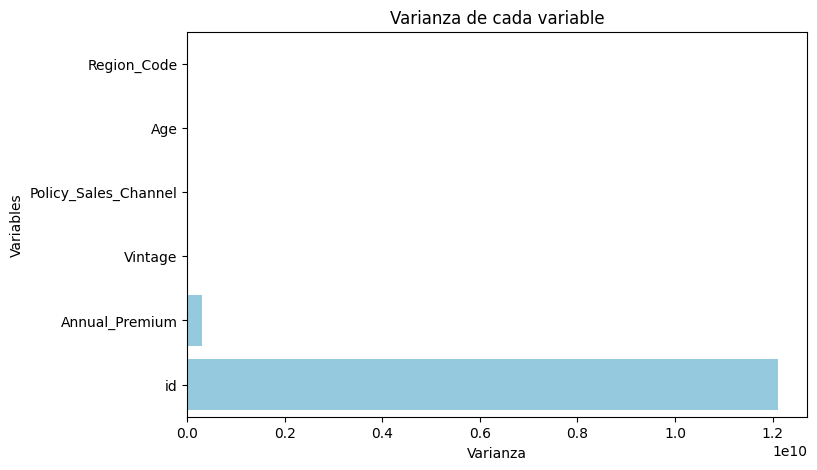

In [18]:
# Crear el gráfico de barras horizontales
plt.figure(figsize=(8, 5))
sns.barplot(x="varianza", y="variable", data=variances_df, orient="h", color='skyblue')
plt.title("Varianza de cada variable")
plt.xlabel("Varianza")
plt.ylabel("Variables")
plt.show()

Como podemos ver la escala de los valores es muy dispersa. Vamos a coregir esto y estandarizar las metricas para poder compararlas. Pare ello utilizareos el coeficiente de variación

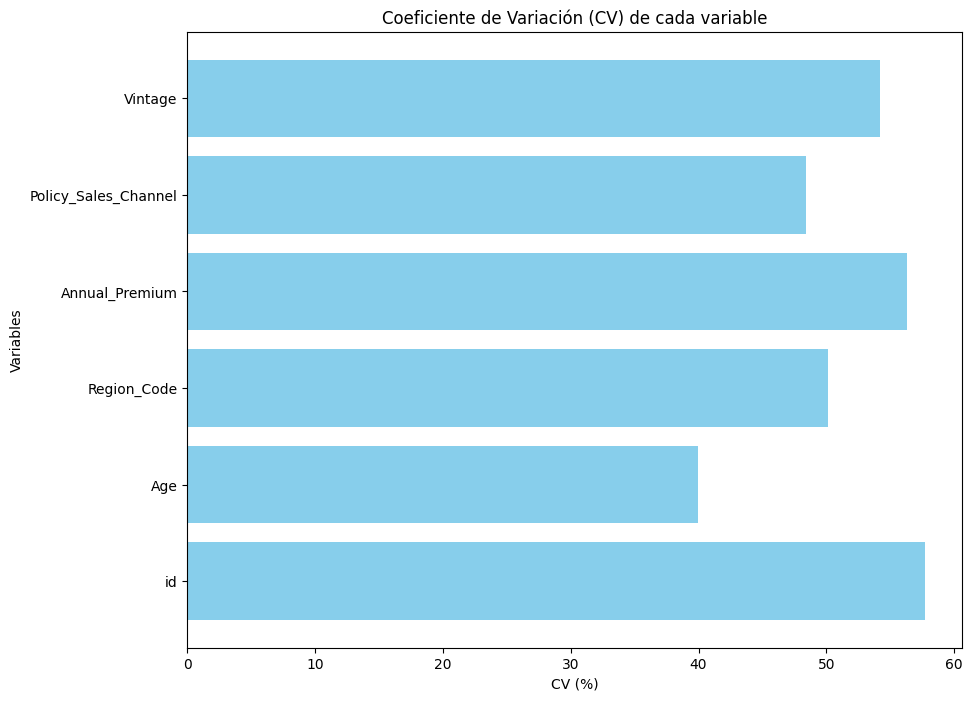

In [21]:
# Calcular el coeficiente de variación (CV)
cv_df = variables_numericas.select([
    (pl.std(col) / pl.mean(col) * 100).alias(col) for col in variables_numericas.columns
])

# Transponer el DataFrame para la visualización
cv_df = cv_df.transpose(include_header=True, header_name="variable", column_names=["cv"])

# Extraer los datos de Polars como listas
variables = cv_df.get_column("variable").to_list()
cvs = cv_df.get_column("cv").to_list()

# Crear el gráfico de barras horizontales con Matplotlib
plt.figure(figsize=(10, 8))
plt.barh(variables, cvs, color='skyblue')
plt.title("Coeficiente de Variación (CV) de cada variable")
plt.xlabel("CV (%)")
plt.ylabel("Variables")
plt.show()

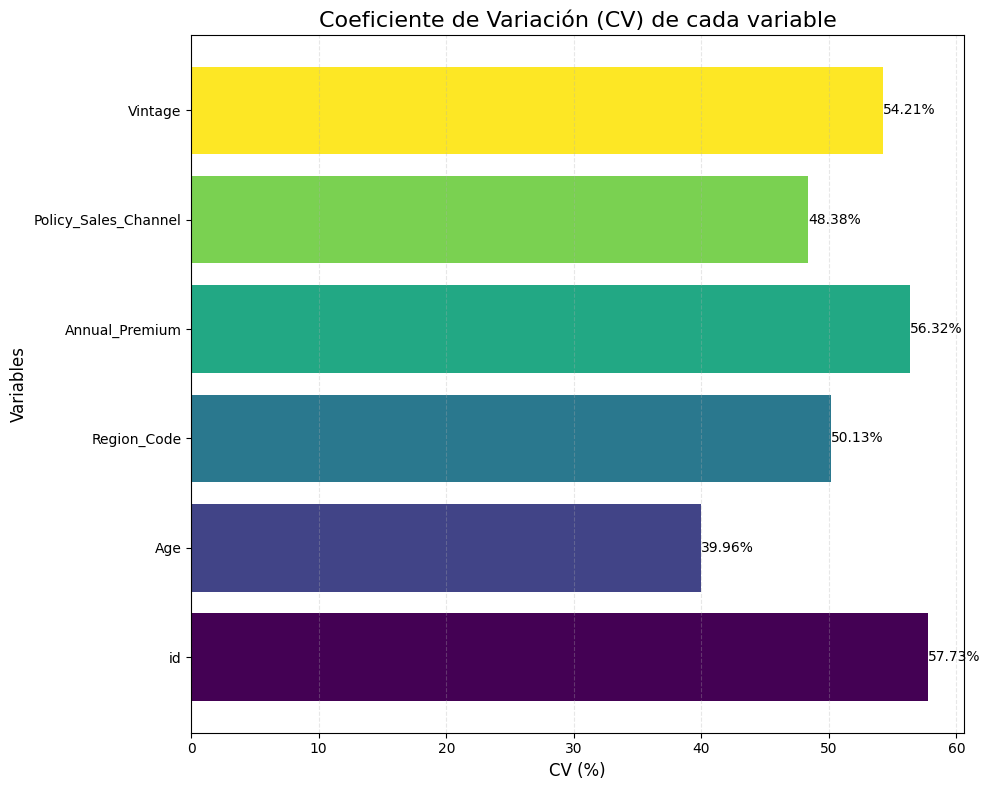

In [27]:
cv_df = variables_numericas.select([
    (pl.std(col) / pl.mean(col) * 100).alias(col) for col in variables_numericas.columns
])

# Transponer el DataFrame para la visualización
cv_df = cv_df.transpose(include_header=True, header_name="variable", column_names=["cv"])

# Extraer los datos de Polars como listas
variables = cv_df.get_column("variable").to_list()
cvs = cv_df.get_column("cv").to_list()

# Crear el gráfico de barras horizontales con Matplotlib
plt.figure(figsize=(10, 8))
bars = plt.barh(variables, cvs, color=plt.cm.viridis(np.linspace(0, 1, len(variables))))

# Añadir etiquetas de valor en las barras
for bar in bars:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,  # Posición de la etiqueta
        f'{bar.get_width():.2f}%', # Texto de la etiqueta
        va='center', ha='left', # Alineación vertical y horizontal
        color='black'
    )

plt.title("Coeficiente de Variación (CV) de cada variable", fontsize=16)
plt.xlabel("CV (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()


Como se pude observar todas las variables numéricas tienen un coeficiente de variación en torno al 50 por ciento lo que no indica ni variabilidad muy alta ni muy baja

### 1.6 - Identifique las filas que contienen datos duplicados


In [33]:
df_duplicates = df_train.filter(df_train.is_duplicated())

print(df_duplicates)

shape: (0, 12)
┌─────┬────────┬─────┬─────────────────┬───┬────────────────┬─────────────────┬─────────┬──────────┐
│ id  ┆ Gender ┆ Age ┆ Driving_License ┆ … ┆ Annual_Premium ┆ Policy_Sales_Ch ┆ Vintage ┆ Response │
│ --- ┆ ---    ┆ --- ┆ ---             ┆   ┆ ---            ┆ annel           ┆ ---     ┆ ---      │
│ i64 ┆ str    ┆ i64 ┆ i64             ┆   ┆ f64            ┆ ---             ┆ i64     ┆ i64      │
│     ┆        ┆     ┆                 ┆   ┆                ┆ f64             ┆         ┆          │
╞═════╪════════╪═════╪═════════════════╪═══╪════════════════╪═════════════════╪═════════╪══════════╡
└─────┴────────┴─────┴─────────────────┴───┴────────────────┴─────────────────┴─────────┴──────────┘


Podemos observar que no existe ninguna fila duplicada

### 1.7 - check the missing values


In [45]:
print(columnas_muchos_valores.keys())

dict_keys(['id', 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'])


In [57]:
for col in df_train.columns: 
    print(f" La columna {col} contiene: {df_train[col].is_null().sum()} valores nulos")

 La columna id contiene: 0 valores nulos
 La columna Gender contiene: 0 valores nulos
 La columna Age contiene: 0 valores nulos
 La columna Driving_License contiene: 0 valores nulos
 La columna Region_Code contiene: 0 valores nulos
 La columna Previously_Insured contiene: 0 valores nulos
 La columna Vehicle_Age contiene: 0 valores nulos
 La columna Vehicle_Damage contiene: 0 valores nulos
 La columna Annual_Premium contiene: 0 valores nulos
 La columna Policy_Sales_Channel contiene: 0 valores nulos
 La columna Vintage contiene: 0 valores nulos
 La columna Response contiene: 0 valores nulos


Podemos observar que no existen valores nulos en el dataset

### 1.8 Detect strange values apart from the NaN Values

Vamos a checkear los outliers

In [ ]:
def detect_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[col].is_between(lower_bound, upper_bound).is_not()

# Aplicar la función de detección de valores atípicos a cada columna
outliers = de

# Mostrar el DataFrame de valores atípicos
print

Vamos a graficar los violincharts de las columnas contínuas, es decir las no categóricas

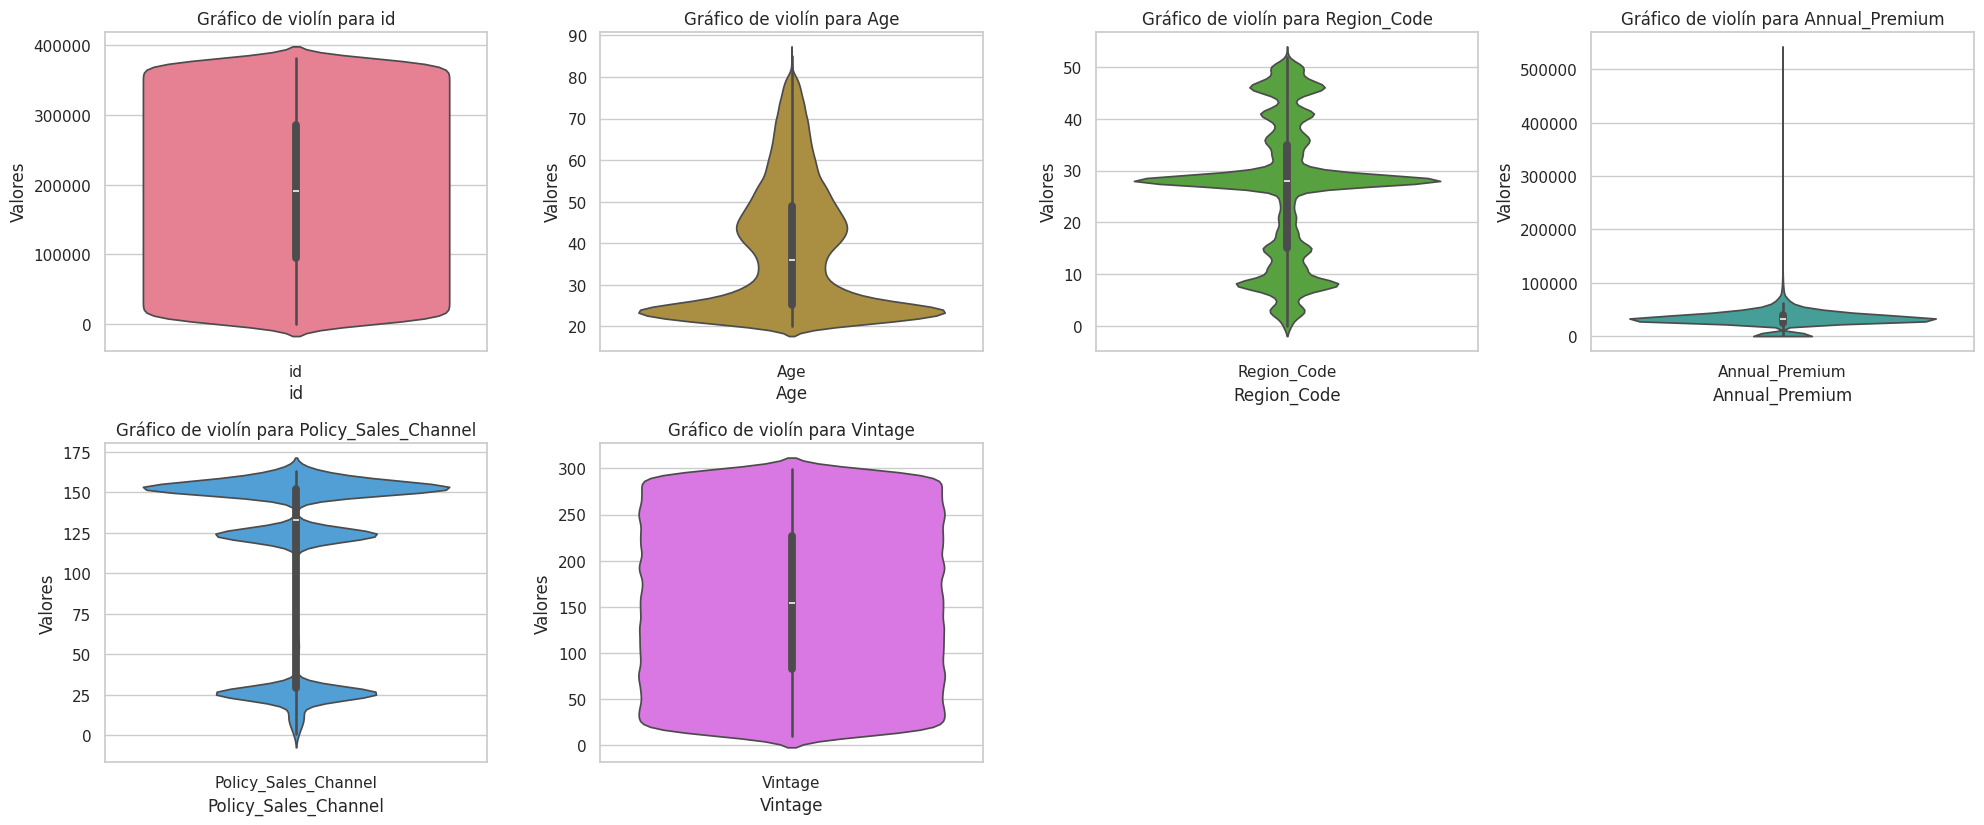

In [72]:
df_pandas = df_train.to_pandas()

# Crear una cuadrícula de gráficos de violín con 4 gráficos por línea
num_cols = len(df_pandas.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(columnas_muchos_valores))


for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.violinplot(ax=axes[row, col], data=df_pandas[[column]], color=palette[i])
    axes[row, col].set_title(f'Gráfico de violín para {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Valores')

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

La columna id la podemos obviar puesto que es una columna de identidiacadores únicos

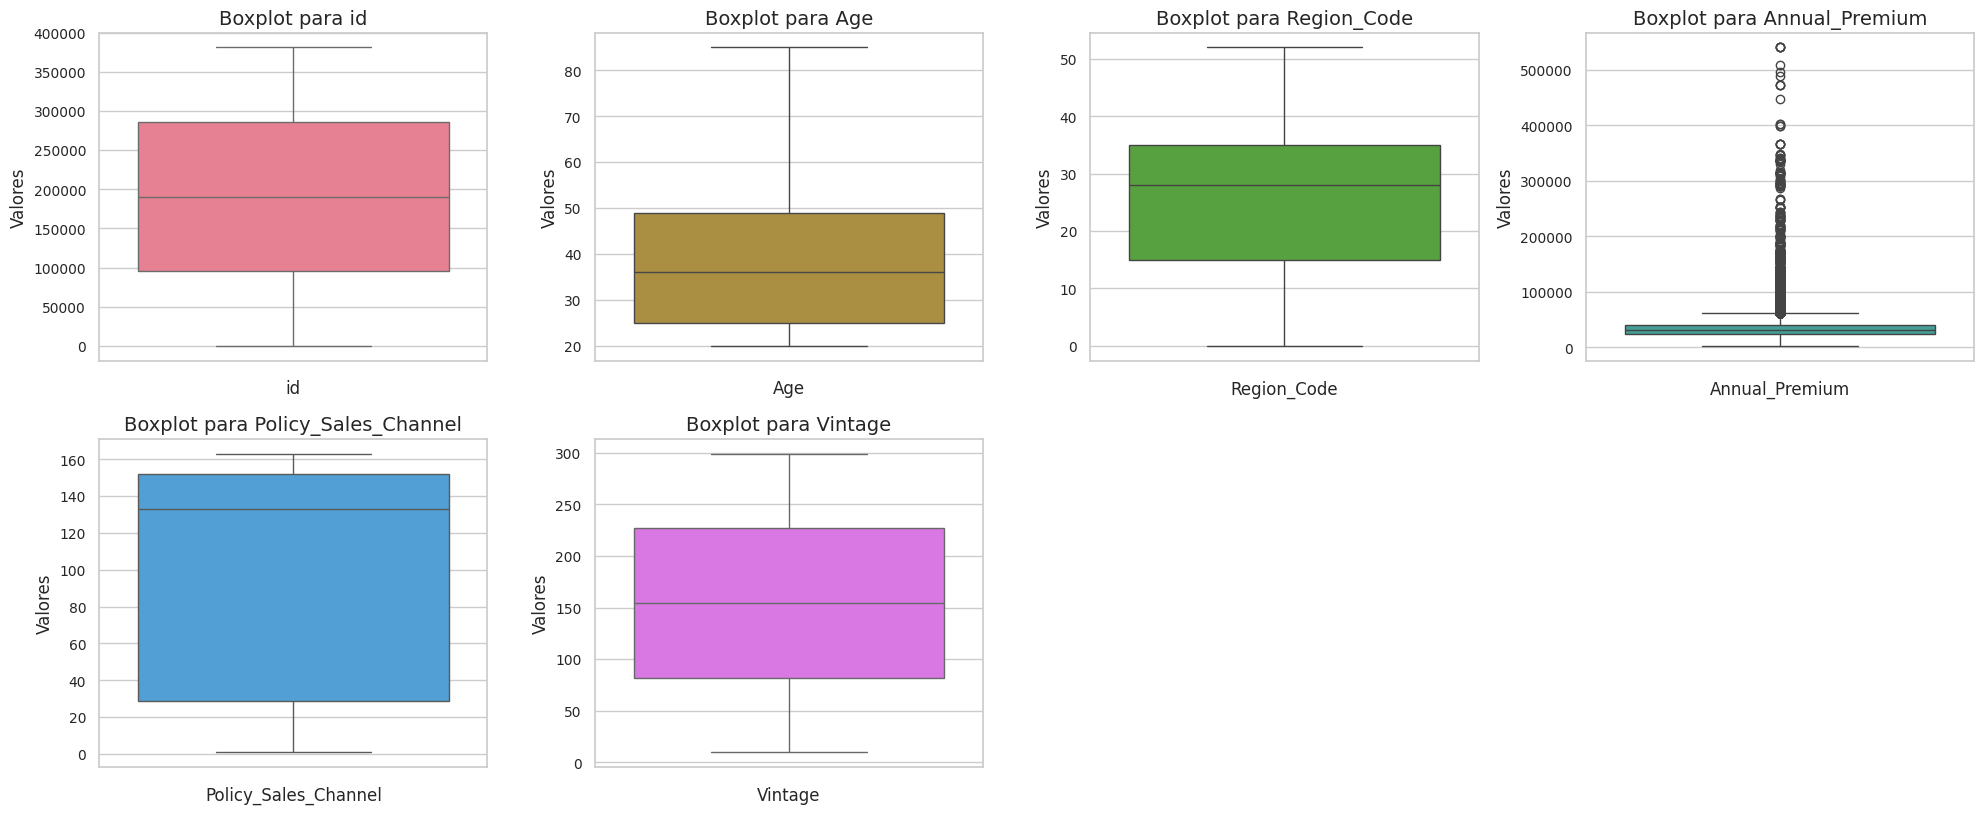

In [69]:
num_cols = len(df_pandas.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))

sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(columnas_muchos_valores))
                            
for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(ax=axes[row, col], data=df_pandas[column],color=palette[i])
    axes[row, col].set_title(f'Boxplot para {column}', fontsize=14)
    axes[row, col].set_xlabel(column, fontsize=12)
    axes[row, col].set_ylabel('Valores', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

# Preguntar duda a Juanjo !!!

### 1.9 - Drop the attributes that provide no useful information


In [73]:
df_train = df_train.drop("id")
df_test = df_test.drop("id")

### 1.10 Plot distributions

Already did on 1.8

---------------------------------------------------------------------------------------------------------------------------------------------------

# 2 Modeling & Evaluation

### 2.1 - Split-out validation dataset


In [77]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train, df_train["Response"], test_size=0.2, random_state=0)

### 2.2 - Feature Selection